# Analysis of the Results

For a given set of tools, automatic test cases are generated. This notebook analyzes the quality of the questions generated along with their diversity and whether they really span the requested combinations of tools.

Note that GPT may generate `functions.<function_name>` instead of just the function name and we account for that.

## Test case generation

We demanded the LLMs to generate test cases including all of their tools. We would like 2 tests per tool (individually) and 2 tests that require exactly 2 of the tools to be answered correctly. Let us verify if this generation was correct.

For each test generation strategy, we want to check:

- Number of test cases generated per tool (individually);
- Number of test cases generated per tool (considering pairs);
- How often the model generated questions that used the tool requested;
- Manually, how many of the questions really need the tools planned.

### Set up and read files

In [1]:
import os
import json
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import self_test_utils as stu

In [2]:
test_gen_strategies = [
    'use_all',
    'only_selected',
    'selected_with_dummies',
]

In [3]:
test_files = [x for x in os.listdir() if x.endswith('.json')]

In [4]:
def read_generated_tests():
    df_tests = None
    for cur_file in test_files:
        with open(cur_file, 'r') as f:
            contents = json.loads(f.read())
            file_info = cur_file.split('_test_cases_')
            df = pd.DataFrame(contents)
            df['gen_strategy'] = file_info[0]
            df['model'] = file_info[1].replace('.json', '')
            if df_tests is None:
                df_tests = df
            else:
                df_tests = pd.concat([df_tests, df])
    return df_tests


df_tests = read_generated_tests()
df_tests

,question,appropriate_tools,expected_tool_to_gen_test,gen_strategy,model,human_verified_tools
0,What day will it be 10 days from today?,[do_date_math],do_date_math,only_selected,Claude 3 Haiku,NaN
1,What date was it 3 weeks and 5 days ago?,[do_date_math],do_date_math,only_selected,Claude 3 Haiku,NaN
2,What day will it be 10 days from today?,[read_write_user_details],read_write_user_details,only_selected,Claude 3 Haiku,NaN
3,Update the user's friends list to remove Josep...,[read_write_user_details],read_write_user_details,only_selected,Claude 3 Haiku,NaN
4,What is the minimum and maximum value in the a...,[make_custom_plot],make_custom_plot,only_selected,Claude 3 Haiku,NaN
...,...,...,...,...,...,...
31,Generate a QR code for the content of 'example...,"[read_local_files, make_qr_code]",NaN,use_all,GPT 4o - OpenAI,NaN
32,Write the current date 10 days from now to 'da...,"[do_date_math, write_local_files]",NaN,use_all,GPT 4o - OpenAI,NaN
33,List all files in the 'C:/Videos' folder and c...,"[read_file_names_in_local_folder, use_ffmpeg]",NaN,use_all,GPT 4o - OpenAI,NaN
34,Sort the contents of 'numbers.txt' in ascendin...,"[read_local_files, solve_with_python]",NaN,use_all,GPT 4o - OpenAI,NaN


In [5]:
# compute all tools that were tested
all_tools = [
    x for x in set(df_tests.expected_tool_to_gen_test.dropna()) if ',' not in x
]
all_tools

['get_url_content',
 'plot_with_graphviz',
 'write_local_files',
 'solve_symbolic',
 'make_qr_code',
 'make_custom_plot',
 'read_local_files',
 'use_ffmpeg',
 'solve_numeric',
 'do_date_math',
 'read_file_names_in_local_folder',
 'solve_with_python',
 'read_write_user_details']

### Number of test cases generated per tool (individually)

In [6]:
# build a dataframe with boolean flags for each tool
df_tests_per_tool = df_tests.copy()
for t in all_tools:
    df_tests_per_tool[t] = df_tests_per_tool.appropriate_tools.map(lambda z: t in str(z).replace('functions.', ''))

cols = ['model', 'gen_strategy'] + all_tools
df_tests_per_tool[cols].groupby(by=['model', 'gen_strategy']).sum()

get_url_content  \
model                         gen_strategy                             
Claude 3 Haiku                only_selected                       16   
                              selected_with_dummies               15   
                              use_all                              1   
Claude 3.5 Sonnet - Anthropic only_selected                       26   
                              selected_with_dummies               26   
                              use_all                              3   
GPT 3.5 - OpenAI              only_selected                       19   
                              selected_with_dummies               21   
                              use_all                              1   
GPT 4o - OpenAI               only_selected                       23   
                              selected_with_dummies               26   
                              use_all                              3   

                                                     plot_with_graphviz  \
model                         gen_strategy                                
Claude 3 Haiku                only_selected                          12   
                              selected_with_dummies                  14   
                              use_all                                 1   
Claude 3.5 Sonnet - Anthropic only_selected                          26   
                              selected_with_dummies                  26   
                              use_all                                 3   
GPT 3.5 - OpenAI              only_selected                          14   
                              selected_with_dummies                  21   
                              use_all                                 1   
GPT 4o - OpenAI               only_selected                          22   
                              selected_with_dummies                  26   
                              use_all                                 3   

                                                     write_local_files  \
model                         gen_strategy                               
Claude 3 Haiku                only_selected                         11   
                              selected_with_dummies                 13   
                              use_all                                1   
Claude 3.5 Sonnet - Anthropic only_selected                         25   
                              selected_with_dummies                 26   
                              use_all                                3   
GPT 3.5 - OpenAI              only_selected                          5   
                              selected_with_dummies                 22   
                              use_all                                1   
GPT 4o - OpenAI               only_selected                         24   
                              selected_with_dummies                 26   
                              use_all                                4   

                                                     solve_symbolic  \
model                         gen_strategy                            
Claude 3 Haiku                only_selected                      14   
                              selected_with_dummies              14   
                              use_all                             1   
Claude 3.5 Sonnet - Anthropic only_selected                      25   
                              selected_with_dummies              26   
                              use_all                             3   
GPT 3.5 - OpenAI              only_selected                      15   
                              selected_with_dummies              17   
                              use_all                             1   
GPT 4o - OpenAI               only_selected                      25   
                              selected_with_dummies              26   
                              use

<Axes: title={'center': 'Number of test cases generated per tool/strategy'}, ylabel='model,gen_strategy'>

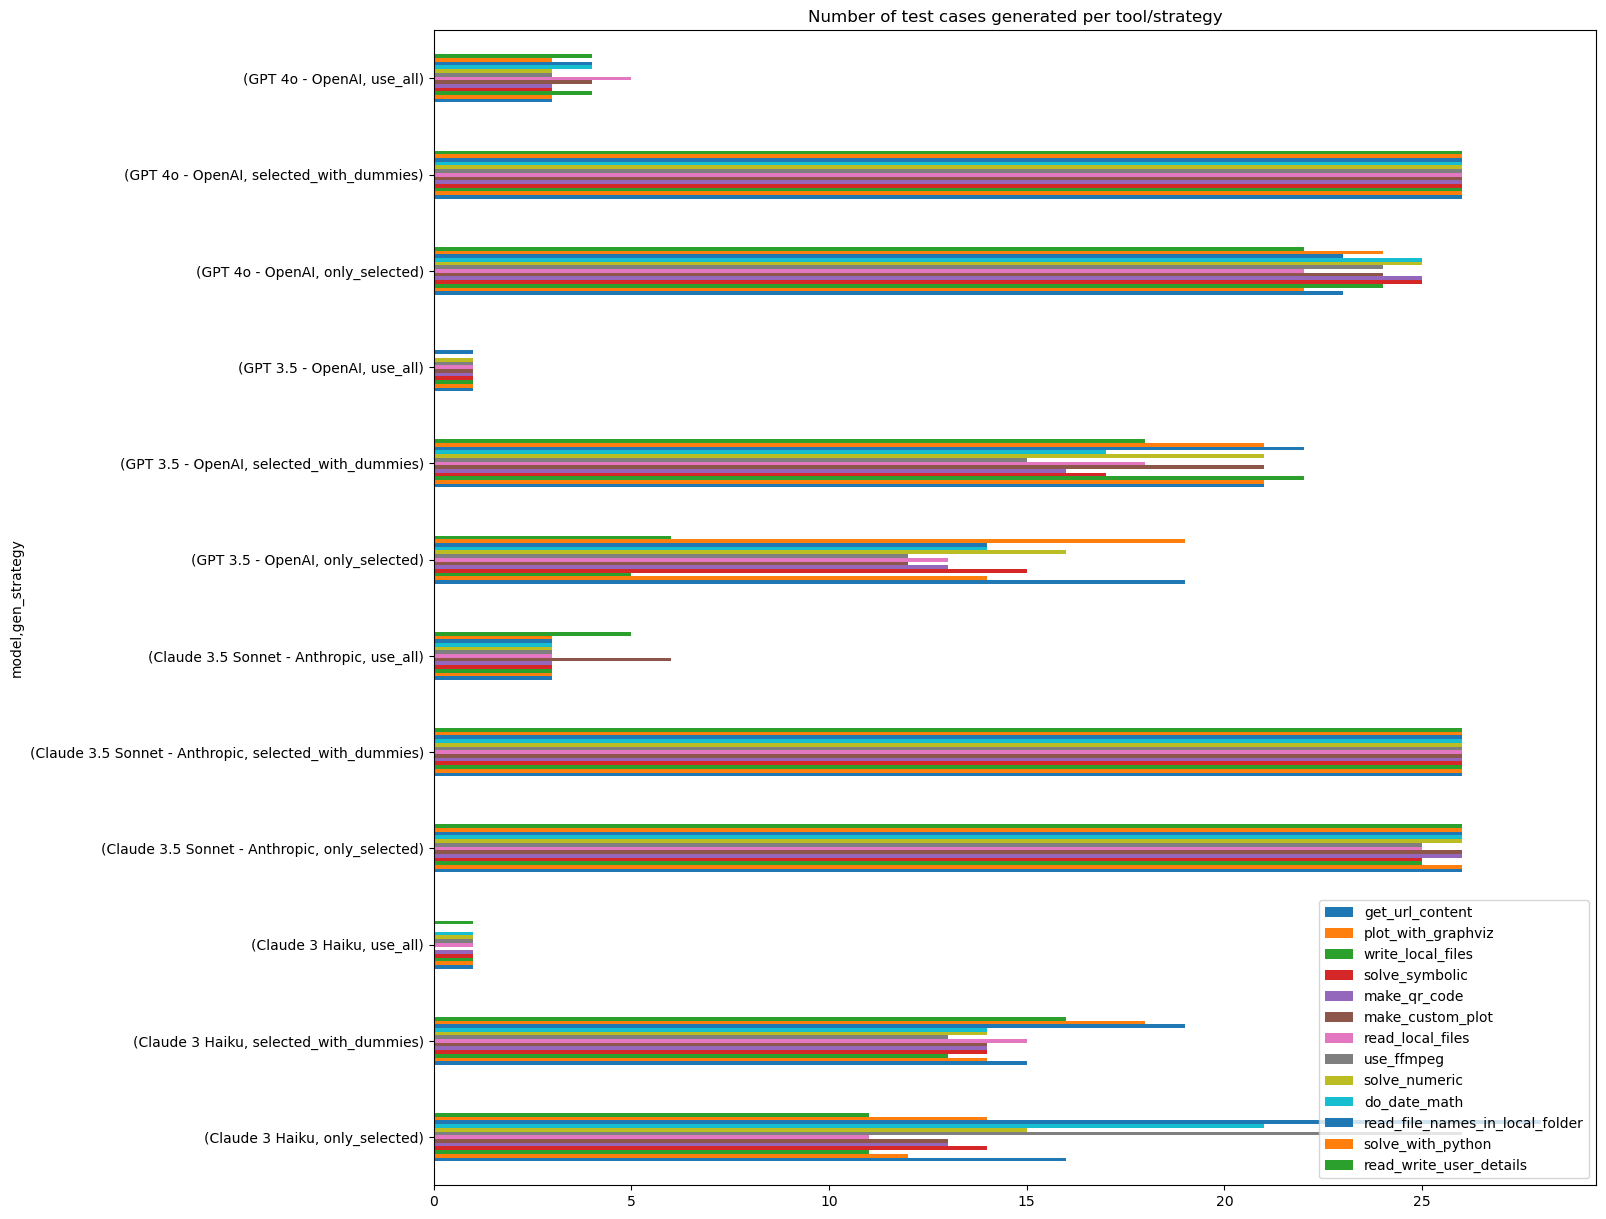

In [7]:
df_tests_per_tool[cols].groupby(
    by=['model', 'gen_strategy']
).sum().plot.barh(figsize=(15, 15), title='Number of test cases generated per tool/strategy')
# plt.xticks(rotation = 45)

<Axes: title={'center': 'Single tool test coverage'}, ylabel='model,gen_strategy'>

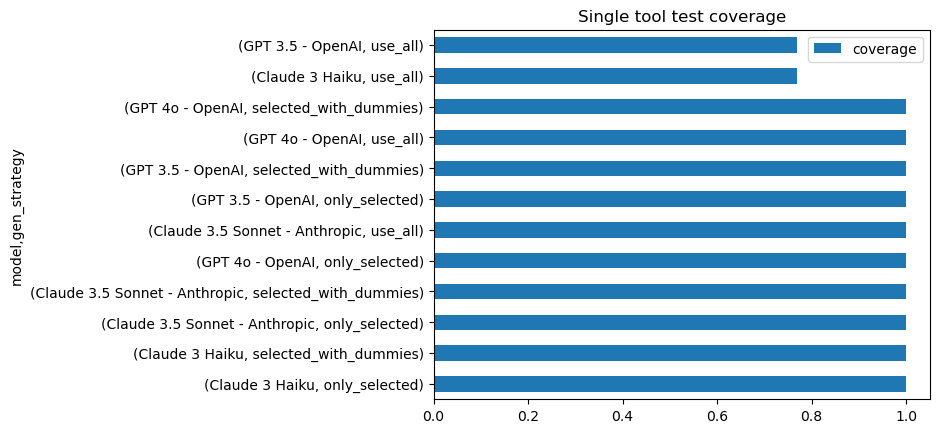

In [8]:
df_agg = df_tests_per_tool[cols].groupby(by=['model', 'gen_strategy']).sum()
df_agg['coverage'] = np.sum(df_agg[all_tools].values > 0, axis=1) / len(all_tools)
df_agg = df_agg.sort_values(by='coverage', ascending=False)
df_agg[['coverage']].plot.barh(title='Single tool test coverage')

In [9]:
# missing coverage
all_missing = []
for idx, r in df_agg[all_tools].iterrows():
    missing_tools = [x for x in all_tools if r[x] == 0]
    all_missing.append(missing_tools)
df_agg['missing_tools'] = all_missing
df_agg[df_agg.coverage < 1][['coverage', 'missing_tools']]

,,coverage,missing_tools
model,gen_strategy,,
Claude 3 Haiku,use_all,0.769231,"[make_custom_plot, read_file_names_in_local_fo..."
GPT 3.5 - OpenAI,use_all,0.769231,"[do_date_math, solve_with_python, read_write_u..."


## Number of test cases generated per tool (considering pairs)

In [10]:
# build a dataframe with boolean flags for tool combinations

all_tools_and_pairs = [[x] for x in all_tools]
for i, t1 in enumerate(all_tools[0:-1]):
    for j, t2 in enumerate(all_tools[i + 1:]):
        all_tools_and_pairs.append([t1, t2])

df_pair_tests_per_tool = df_tests.copy()
df_pair_tests_per_tool['invented_tools'] = df_pair_tests_per_tool.appropriate_tools.map(lambda z: stu.detect_invented_tools(z, all_tools))
tool_cols = [','.join(t) for t in all_tools_and_pairs]
for t in all_tools_and_pairs:
    df_pair_tests_per_tool[','.join(t)] = df_pair_tests_per_tool.appropriate_tools.map(lambda z: stu.belongs_to_col(z, t))

In [11]:
# df_agg.columns

In [12]:
cols = ['model', 'gen_strategy'] + tool_cols
df_pair_tests_per_tool[cols].groupby(by=['model', 'gen_strategy']).sum()

get_url_content  \
model                         gen_strategy                             
Claude 3 Haiku                only_selected                       16   
                              selected_with_dummies               15   
                              use_all                              1   
Claude 3.5 Sonnet - Anthropic only_selected                       26   
                              selected_with_dummies               26   
                              use_all                              3   
GPT 3.5 - OpenAI              only_selected                       19   
                              selected_with_dummies               21   
                              use_all                              1   
GPT 4o - OpenAI               only_selected                       23   
                              selected_with_dummies               26   
                              use_all                              3   

                                                     plot_with_graphviz  \
model                         gen_strategy                                
Claude 3 Haiku                only_selected                          12   
                              selected_with_dummies                  14   
                              use_all                                 1   
Claude 3.5 Sonnet - Anthropic only_selected                          26   
                              selected_with_dummies                  26   
                              use_all                                 3   
GPT 3.5 - OpenAI              only_selected                          14   
                              selected_with_dummies                  21   
                              use_all                                 1   
GPT 4o - OpenAI               only_selected                          22   
                              selected_with_dummies                  26   
                              use_all                                 3   

                                                     write_local_files  \
model                         gen_strategy                               
Claude 3 Haiku                only_selected                         10   
                              selected_with_dummies                 13   
                              use_all                                1   
Claude 3.5 Sonnet - Anthropic only_selected                         25   
                              selected_with_dummies                 26   
                              use_all                                3   
GPT 3.5 - OpenAI              only_selected                          5   
                              selected_with_dummies                 22   
                              use_all                                1   
GPT 4o - OpenAI               only_selected                         24   
                              selected_with_dummies                 26   
                              use_all                                4   

                                                     solve_symbolic  \
model                         gen_strategy                            
Claude 3 Haiku                only_selected                      14   
                              selected_with_dummies              14   
                              use_all                             1   
Claude 3.5 Sonnet - Anthropic only_selected                      25   
                              selected_with_dummies              26   
                              use_all                             3   
GPT 3.5 - OpenAI              only_selected                      15   
                              selected_with_dummies              17   
                              use_all                             1   
GPT 4o - OpenAI               only_selected                      25   
                              selected_with_dummies              26   
                              use

<Axes: title={'center': 'Single and pairwise tool test coverage'}, ylabel='model,gen_strategy'>

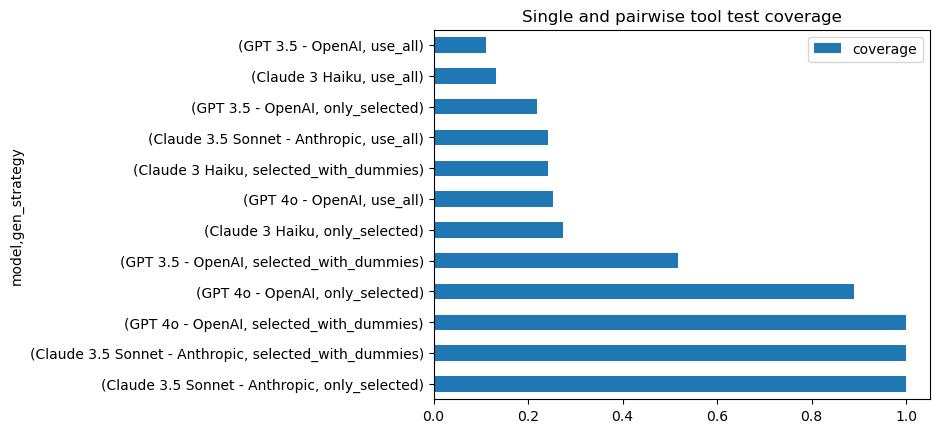

In [13]:
df_agg = df_pair_tests_per_tool[cols].groupby(by=['model', 'gen_strategy']).sum()
df_agg['coverage'] = np.sum(df_agg[tool_cols].values > 0, axis=1) / len(tool_cols)
df_agg = df_agg.sort_values(by='coverage', ascending=False)
df_agg[['coverage']].plot.barh(title='Single and pairwise tool test coverage')

In [14]:
# missing coverage and invented tools
from IPython.display import display, Math, Latex

all_missing = []
for idx, r in df_agg[tool_cols].iterrows():
    missing_tools = [x for x in tool_cols if r[x] == 0]
    all_missing.append(missing_tools)
df_agg['missing_tools'] = all_missing

latex_tbl = df_agg[df_agg.coverage <= 1][['coverage']].to_latex(float_format="{:.2f}".format,)
df_agg[df_agg.coverage <= 1][['coverage', 'missing_tools']]

coverage  \
model                         gen_strategy                      
Claude 3.5 Sonnet - Anthropic only_selected          1.000000   
                              selected_with_dummies  1.000000   
GPT 4o - OpenAI               selected_with_dummies  1.000000   
                              only_selected          0.890110   
GPT 3.5 - OpenAI              selected_with_dummies  0.516484   
Claude 3 Haiku                only_selected          0.274725   
GPT 4o - OpenAI               use_all                0.252747   
Claude 3 Haiku                selected_with_dummies  0.241758   
Claude 3.5 Sonnet - Anthropic use_all                0.241758   
GPT 3.5 - OpenAI              only_selected          0.219780   
Claude 3 Haiku                use_all                0.131868   
GPT 3.5 - OpenAI              use_all                0.109890   

                                                                                         missing_tools  
model                         gen_strategy                                                              
Claude 3.5 Sonnet - Anthropic only_selected                                                         []  
                              selected_with_dummies                                                 []  
GPT 4o - OpenAI               selected_with_dummies                                                 []  
                              only_selected          [get_url_content,read_local_files, get_url_con...  
GPT 3.5 - OpenAI              selected_with_dummies  [get_url_content,read_local_files, get_url_con...  
Claude 3 Haiku                only_selected          [get_url_content,solve_symbolic, get_url_conte...  
GPT 4o - OpenAI               use_all                [get_url_content,plot_with_graphviz, get_url_c...  
Claude 3 Haiku                selected_with_dummies  [get_url_content,plot_with_graphviz, get_url_c...  
Claude 3.5 Sonnet - Anthropic use_all                [get_url_content,plot_with_graphviz, get_url_c...  
GPT 3.5 - OpenAI              only_selected          [get_url_content,plot_with_graphviz, get_url_c...  
Claude 3 Haiku                use_all                [make_custom_plot, read_file_names_in_local_fo...  
GPT 3.5 - OpenAI              use_all                [do_date_math, solve_with_python, read_write_u...

In [15]:
# export for paper
# print(latex_tbl.replace('_', '\\_').replace(' - Anthropic', '').replace(' - OpenAI', '').replace(' - Bedrock', ''))

In [16]:
df_pair_tests_per_tool[df_pair_tests_per_tool['invented_tools'] != ''].groupby(['model', 'gen_strategy']).count()['question']

model             gen_strategy 
Claude 3 Haiku    only_selected     4
GPT 3.5 - OpenAI  only_selected    25
GPT 4o - OpenAI   only_selected     6
Name: question, dtype: int64

In [17]:
# [stu.detect_invented_tools(x) for x in df_tests.appropriate_tools[20:40]]

In [18]:
# set([stu.detect_invented_tools(x) for x in df_tests.appropriate_tools])

## Manual verification

In [19]:
manually_verified_files = [
    'selected_with_dummies_test_cases_GPT 4o - OpenAI.json',
    'selected_with_dummies_test_cases_Claude 3.5 Sonnet - Anthropic.json',
]

In [20]:
def check_human_answers(df, file):
    list_is_correct = []
    list_score = []
    list_invented_tools = []
    list_is_empty_pred = []
    for idx, row in df.iterrows():
        is_correct, score, invented_tools, is_empty_pred = stu.is_tool_selection_correct(
            json.dumps(row['human_verified_tools']),
            json.dumps(row['appropriate_tools']),
            all_tools
        )
        list_is_correct.append(is_correct)
        list_score.append(score)
        list_invented_tools.append(invented_tools)
        list_is_empty_pred.append(is_empty_pred)
    df['is_correct'] = list_is_correct
    df['score'] = list_score
    df['invented_tools'] = list_invented_tools
    df['is_empty_pred'] = list_is_empty_pred
    df['file'] = file
    return df

In [21]:
manual_verif_dfs = None
for cur_file in manually_verified_files:
    with open(cur_file, 'r') as f:
        cur_data = json.loads(f.read())
    df = pd.DataFrame(cur_data)
    check_human_answers(df, cur_file)
    if manual_verif_dfs is None:
        manual_verif_dfs = df
    else:
        manual_verif_dfs = pd.concat([manual_verif_dfs, df])

In [22]:
manual_verif_dfs.head(2)

,question,appropriate_tools,human_verified_tools,expected_tool_to_gen_test,is_correct,score,invented_tools,is_empty_pred,file
0,"What is the date 3 months after July 4, 2024?",[do_date_math],[do_date_math],do_date_math,True,1.0,[],False,selected_with_dummies_test_cases_GPT 4o - Open...
1,"What was the date 2 weeks before July 4, 2024?",[do_date_math],[do_date_math],do_date_math,True,1.0,[],False,selected_with_dummies_test_cases_GPT 4o - Open...


In [23]:
manual_verif_dfs.groupby(by=['file']).agg(
    {
        'question': ['count'],
        'is_correct': ['mean'],
        'score': ['mean'],
        'is_empty_pred': ['sum'],
        # 'n_invented_tools': ['sum'],
    }
)

,question,is_correct,score,is_empty_pred
,count,mean,mean,sum
file,,,,
selected_with_dummies_test_cases_Claude 3.5 Sonnet - Anthropic.json,182,0.967033,0.987179,0
selected_with_dummies_test_cases_GPT 4o - OpenAI.json,182,0.945055,0.969780,0


# Evaluation

Make sure to test when

- No tools were planned
- Tools invoked when we explicitly asked not to
- Tool names were made up
- Correct tools planned
- Only one of the correct tools was planned

Note that we only evaluate answers given in valid JSON format enclosed within \<answer>\</answer> tags, as requested in the prompt.

In [24]:
eval_files = [x for x in os.listdir() if x.startswith('self_test_results')]
eval_files

['self_test_results_Amazon Nova Lite 1.0 - Bedrock_True.csv',
 'self_test_results_Amazon Nova Micro 1.0 - Bedrock_True.csv',
 'self_test_results_Amazon Nova Pro 1.0 - Bedrock_True.csv',
 'self_test_results_Claude 3 Haiku - Bedrock_False.csv',
 'self_test_results_Claude 3 Haiku - Bedrock_True.csv',
 'self_test_results_Claude 3.5 Haiku - Anthropic_False.csv',
 'self_test_results_Claude 3.5 Haiku - Anthropic_True.csv',
 'self_test_results_Claude 3.5 Sonnet - Anthropic_False.csv',
 'self_test_results_Claude 3.5 Sonnet - Anthropic_True.csv',
 'self_test_results_Claude 3.7 Sonnet - Anthropic_True.csv',
 'self_test_results_Command R - Bedrock_False.csv',
 'self_test_results_Command RPlus - Bedrock_False.csv',
 'self_test_results_DeepSeekV3 Chat - DeepSeek_False.csv',
 'self_test_results_GPT 3.5 - OpenAI_False.csv',
 'self_test_results_GPT 3.5 - OpenAI_True.csv',
 'self_test_results_GPT 4.1 - OpenAI_True.csv',
 'self_test_results_GPT 4o - OpenAI_False.csv',
 'self_test_results_GPT 4o - OpenAI_

In [25]:
df_eval_models = None
for cur_eval_file in eval_files:
    df = pd.read_csv(cur_eval_file)
    if df_eval_models is None:
        df_eval_models = df
    else:
        df_eval_models = pd.concat([df_eval_models, df])

# evaluate accuracy
is_correct = []
invented_tools = []
scores = []
is_pred_empty = []
for idx, r in df_eval_models.iterrows():
    cur_correct, cur_score, cur_invented, cur_empty = stu.is_tool_selection_correct(
        r['expected_answer'], r['parsed_tool_names'], all_tools, r['model']
    )
    is_correct.append(cur_correct)
    invented_tools.append(cur_invented)
    scores.append(cur_score)
    is_pred_empty.append(cur_empty)
df_eval_models['scores'] = scores
df_eval_models['is_correct'] = is_correct
df_eval_models['n_invented_tools'] = [len(x) for x in invented_tools]
df_eval_models['invented_tools'] = invented_tools
df_eval_models['is_pred_empty'] = is_pred_empty

In [26]:
df_eval_models

,model,use_native_tools,question,source_file,raw_answer,parsed_tool_names,expected_answer,scores,is_correct,n_invented_tools,invented_tools,is_pred_empty
0,Amazon Nova Lite 1.0 - Bedrock,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_Cl...,<tool_use_plan>do_date_math</tool_use_plan>\r\n,['do_date_math'],['do_date_math'],1.000000,True,0,[],False
1,Amazon Nova Lite 1.0 - Bedrock,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_Cl...,<tool_use_plan>do_date_math</tool_use_plan>\r\n,['do_date_math'],['do_date_math'],1.000000,True,0,[],False
2,Amazon Nova Lite 1.0 - Bedrock,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_Cl...,<tool_use_plan>read_write_user_details</tool_u...,['read_write_user_details'],['read_write_user_details'],1.000000,True,0,[],False
3,Amazon Nova Lite 1.0 - Bedrock,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_Cl...,<tool_use_plan>read_write_user_details:read_wr...,['read_write_user_details:read_write_user_deta...,['read_write_user_details'],1.000000,True,0,[],False
4,Amazon Nova Lite 1.0 - Bedrock,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_Cl...,"<tool_use_plan>solve_numeric, make_custom_plot...","['solve_numeric', 'make_custom_plot']",['make_custom_plot'],0.500000,False,0,[],False
...,...,...,...,...,...,...,...,...,...,...,...,...
359,Sabia3 - Maritaca,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_GP...,To concatenate two videos and rename the resu...,['use_ffmpeg'],"['use_ffmpeg', 'solve_with_python']",0.500000,False,0,[],False
360,Sabia3 - Maritaca,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_GP...,To create a video that visualizes the structur...,"['plot_with_graphviz', 'use_ffmpeg']","['plot_with_graphviz', 'use_ffmpeg']",1.000000,True,0,[],False
361,Sabia3 - Maritaca,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_GP...,"<tool_use_plan>plot_with_graphviz,use_ffmpeg<...","['plot_with_graphviz', 'use_ffmpeg']","['plot_with_graphviz', 'use_ffmpeg']",1.000000,True,0,[],False
362,Sabia3 - Maritaca,True,Consider the following <question></question>:\...,self_tests\selected_with_dummies_test_cases_GP...,"To solve the problem, we need to perform two ...","['solve_with_python', 'make_custom_plot']","['solve_with_python', 'plot_with_graphviz']",0.333333,False,0,[],False


In [27]:
agg_eval = df_eval_models.groupby(by=['model', 'use_native_tools']).agg(
    {
        'question': ['count'],
        'is_correct': ['sum'],
        'scores': ['sum'],
        'is_pred_empty': ['sum'],
        'n_invented_tools': ['sum'],
    }
)
agg_eval[('accuracy', '%')] = agg_eval.values[:,1] / agg_eval.values[:,0]
agg_eval[('score', '%')] = agg_eval.values[:,2] / agg_eval.values[:,0]
agg_eval = agg_eval.sort_values(by=('score', '%'), ascending=False)
agg_eval

,,question,is_correct,scores,is_pred_empty,n_invented_tools,accuracy,score
,,count,sum,sum,sum,sum,%,%
model,use_native_tools,,,,,,,
DeepSeekV3 Chat - DeepSeek,False,364,289,326.166667,1,1,0.793956,0.896062
Claude 3.5 Sonnet - Anthropic,False,364,284,325.900000,0,0,0.780220,0.895330
GPT 4o - OpenAI,True,364,291,325.583333,0,1,0.799451,0.894460
GPT 4o mini - OpenAI,True,364,291,323.916667,0,3,0.799451,0.889881
GPT 4.1 - OpenAI,True,364,286,323.916667,0,1,0.785714,0.889881
Claude 3.5 Haiku - Anthropic,True,364,279,323.833333,0,2,0.766484,0.889652
Amazon Nova Pro 1.0 - Bedrock,True,364,284,323.000000,0,1,0.780220,0.887363
Claude 3.5 Sonnet - Anthropic,True,364,279,322.833333,0,0,0.766484,0.886905


In [28]:
import sys
sys.path.append('..')

import gat_llm.llm_invoker as inv

# get model costs
inp_prices = []
out_prices = []
for x in agg_eval.index:
    print(x[0])
    cur_llm = inv.LLM_Provider.get_llm(None, x[0])
    inp_prices.append(cur_llm.price_per_M_input_tokens)
    out_prices.append(cur_llm.price_per_M_output_tokens)
agg_eval[("USD / 1M tokens", "Input")] = inp_prices
agg_eval[("USD / 1M tokens", "Output")] = out_prices

cols_of_interest = [
            ('n_invented_tools',              'sum'),
            (        'accuracy',                '%'),
            (           'score',                '%'),
            ("USD / 1M tokens",  'Input'),
            ("USD / 1M tokens", 'Output')
]

agg_eval = agg_eval[cols_of_interest].copy()

agg_eval[('accuracy','%')] = agg_eval[('accuracy','%')].map(lambda z: np.round(100 * z, 1))
agg_eval[('score','%')] = agg_eval[('score','%')].map(lambda z: np.round(100 * z, 1))

agg_eval

DeepSeekV3 Chat - DeepSeek
Claude 3.5 Sonnet - Anthropic


C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: Claude 3.5 Sonnet - Anthropic. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)


GPT 4o - OpenAI
GPT 4o mini - OpenAI
GPT 4.1 - OpenAI
Claude 3.5 Haiku - Anthropic


C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: GPT 4o - OpenAI. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)
C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: GPT 4o mini - OpenAI. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)
C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: GPT 4.1 - OpenAI. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)


Amazon Nova Pro 1.0 - Bedrock
Claude 3.5 Sonnet - Anthropic


C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: Claude 3.5 Sonnet - Anthropic. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)


Claude 3 Haiku - Bedrock
Claude 3.5 Haiku - Anthropic


C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: Claude 3 Haiku - Bedrock. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)


GPT 4o - OpenAI
Llama3_1 405b instruct
Claude 3.7 Sonnet - Anthropic


C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: GPT 4o - OpenAI. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)


Mistral Large v1
GPT 4o mini - OpenAI
GPT 5 - OpenAI
Command RPlus - Bedrock
Claude 3 Haiku - Bedrock
Sabia3 - Maritaca
GPT 5 mini - OpenAI
Amazon Nova Lite 1.0 - Bedrock
Llama3_1 70b instruct
GPT 5 nano - OpenAI
GPT 3.5 - OpenAI
GPT 3.5 - OpenAI
OpenAI GPT OSS 20b - Ollama


C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: GPT 4o mini - OpenAI. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)
C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: Claude 3 Haiku - Bedrock. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)
C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: GPT 3.5 - OpenAI. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)
C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: GPT 3.5 - OpenAI. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)


Sabia3 - Maritaca
Mistral Mixtral 8x7B
Amazon Nova Micro 1.0 - Bedrock
Command R - Bedrock
Llama3 8b instruct
Llama3 70b instruct
Llama3_1 8b instruct
Grok2Vision - Grok
Qwen 3 8b - Ollama


C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: Llama3 8b instruct. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)
C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: Llama3 70b instruct. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)
C:\Users\Douglas\Desktop\dev\SelfTestingGAT_LLM\self_tests\..\gat_llm\llm_invoker.py:107: DeprecationWarning: Selected model is outdated: Grok2Vision - Grok. Consider switching to a newer model.
  warnings.warn(warn_msg, DeprecationWarning)


Qwen 3 14b - Ollama


n_invented_tools accuracy  \
                                                              sum        %   
model                           use_native_tools                             
DeepSeekV3 Chat - DeepSeek      False                           1     79.4   
Claude 3.5 Sonnet - Anthropic   False                           0     78.0   
GPT 4o - OpenAI                 True                            1     79.9   
GPT 4o mini - OpenAI            True                            3     79.9   
GPT 4.1 - OpenAI                True                            1     78.6   
Claude 3.5 Haiku - Anthropic    True                            2     76.6   
Amazon Nova Pro 1.0 - Bedrock   True                            1     78.0   
Claude 3.5 Sonnet - Anthropic   True                            0     76.6   
Claude 3 Haiku - Bedrock        True                            2     77.5   
Claude 3.5 Haiku - Anthropic    False                           9     73.9   
GPT 4o - OpenAI                 False                           4     76.6   
Llama3_1 405b instruct          False                           3     75.5   
Claude 3.7 Sonnet - Anthropic   True                            2     74.7   
Mistral Large v1                False                           1     74.7   
GPT 4o mini - OpenAI            False                           3     73.1   
GPT 5 - OpenAI                  True                            3     69.5   
Command RPlus - Bedrock         False                           4     72.8   
Claude 3 Haiku - Bedrock        False                           3     70.6   
Sabia3 - Maritaca               True                            6     70.6   
GPT 5 mini - OpenAI             True                           16     69.0   
Amazon Nova Lite 1.0 - Bedrock  True                            2     66.2   
Llama3_1 70b instruct           False                          11     70.0   
GPT 5 nano - OpenAI             True                           21     63.5   
GPT 3.5 - OpenAI                False                           2     65.4   
                                True                           18     66.4   
OpenAI GPT OSS 20b - Ollama     True                           17     60.7   
Sabia3 - Maritaca               False                          14     61.8   
Mistral Mixtral 8x7B            False                         156     50.1   
Amazon Nova Micro 1.0 - Bedrock True                          145     52.5   
Command R - Bedrock             False                         117     49.7   
Llama3 8b instruct              False                          39     22.3   
Llama3 70b instruct             False                          29     29.1   
Llama3_1 8b instruct            False                          34     23.9   
Grok2Vision - Grok              True                            1     25.0   
Qwen 3 8b - Ollama              True                          458      0.0   
Qwen 3 14b - Ollama             True                          433      0.0   

                                                 score USD / 1M tokens         
                                                     %           Input Output  
model                           use_native_tools                               
DeepSeekV3 Chat - DeepSeek      False             89.6           0.270   1.10  
Claude 3.5 Sonnet - Anthropic   False             89.5           3.000  15.00  
GPT 4o - OpenAI                 True              89.4           5.000  15.00  
GPT 4o mini - OpenAI            True              89.0           0.150   0.60  
GPT 4.1 - OpenAI                True              89.0           2.000   8.00  
Claude 3.5 Haiku - Anthropic    True              89.0           1.000   5.00  
Amazon Nova Pro 1.0 - Bedrock   True              88.7           0.800   3.20  
Claude 3.5 Sonnet - Anthropic   True              88.7           3.000  15.00  
Claude 3 Haiku - Bedrock        True              88.6           0.250   1.25  
Claude 3.5 Haiku - Anthropic    False         

In [29]:
# export for readme
markdown_tbl = agg_eval.to_markdown()
print(markdown_tbl)

|                                           |   ('n_invented_tools', 'sum') |   ('accuracy', '%') |   ('score', '%') |   ('USD / 1M tokens', 'Input') |   ('USD / 1M tokens', 'Output') |
|:------------------------------------------|------------------------------:|--------------------:|-----------------:|-------------------------------:|--------------------------------:|
| ('DeepSeekV3 Chat - DeepSeek', False)     |                             1 |                79.4 |             89.6 |                          0.27  |                            1.1  |
| ('Claude 3.5 Sonnet - Anthropic', False)  |                             0 |                78   |             89.5 |                          3     |                           15    |
| ('GPT 4o - OpenAI', True)                 |                             1 |                79.9 |             89.4 |                          5     |                           15    |
| ('GPT 4o mini - OpenAI', True)            |                         

In [30]:
# export for paper
latex_tbl = agg_eval.to_latex(float_format="{:.2f}".format,)
print(latex_tbl.replace('_', '\\_').replace(' - Anthropic', '').replace(' - OpenAI', '').replace(' - Bedrock', ''))

\begin{tabular}{llrrrrr}
\toprule
 &  & n\_invented\_tools & accuracy & score & \multicolumn{2}{r}{USD / 1M tokens} \\
 &  & sum & % & % & Input & Output \\
model & use\_native\_tools &  &  &  &  &  \\
\midrule
DeepSeekV3 Chat - DeepSeek & False & 1 & 79.40 & 89.60 & 0.27 & 1.10 \\
\cline{1-7}
Claude 3.5 Sonnet & False & 0 & 78.00 & 89.50 & 3.00 & 15.00 \\
\cline{1-7}
GPT 4o & True & 1 & 79.90 & 89.40 & 5.00 & 15.00 \\
\cline{1-7}
GPT 4o mini & True & 3 & 79.90 & 89.00 & 0.15 & 0.60 \\
\cline{1-7}
GPT 4.1 & True & 1 & 78.60 & 89.00 & 2.00 & 8.00 \\
\cline{1-7}
Claude 3.5 Haiku & True & 2 & 76.60 & 89.00 & 1.00 & 5.00 \\
\cline{1-7}
Amazon Nova Pro 1.0 & True & 1 & 78.00 & 88.70 & 0.80 & 3.20 \\
\cline{1-7}
Claude 3.5 Sonnet & True & 0 & 76.60 & 88.70 & 3.00 & 15.00 \\
\cline{1-7}
Claude 3 Haiku & True & 2 & 77.50 & 88.60 & 0.25 & 1.25 \\
\cline{1-7}
Claude 3.5 Haiku & False & 9 & 73.90 & 87.90 & 1.00 & 5.00 \\
\cline{1-7}
GPT 4o & False & 4 & 76.60 & 87.70 & 5.00 & 15.00 \\
\cline{1-7}

In [31]:
df_eval_models[(df_eval_models.model == 'GPT 4o - OpenAI') & (df_eval_models.n_invented_tools > 0)].iloc[0].to_dict()

{'model': 'GPT 4o - OpenAI',
 'use_native_tools': False,
 'question': 'Consider the following <question></question>:\r\n<question>\r\nWhat is the current price of Bitcoin in USD, and how much would 2.5 bitcoins be worth?\r\n</question>\r\nPlan what tool or tools are needed to answer the previous question.\r\nDo NOT use any tools yet - only mention which ones will be necessary. Do not repeat the question.\r\nExplain your choices before giving the final answer.\r\nYour final answer should contain only the tool names separated by colon in <tool_use_plan></tool_use_plan> tags.\r\nExample answers: <tool_use_plan>find_ticker_name</tool_use_plan>, <tool_use_plan>find_ticker_name,retrieve_price</tool_use_plan>',
 'source_file': 'self_tests\\selected_with_dummies_test_cases_Claude 3.5 Sonnet - Anthropic.json',
 'raw_answer': '<scratchpad> I can only use functions that have been explicitly provided. I must follow the <tool_guidelines></tool_guidelines>. I need the following tools:<tool_use_plan>